<h1>Imports and setup</h1>

In [1]:
from collections import defaultdict
import csv
import itertools
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import spearmanr

import vsm
import utils

In [2]:
utils.fix_random_seeds()

In [3]:
VSM_HOME = os.path.join('data', 'vsmdata')

DATA_HOME = os.path.join('data', 'wordrelatedness')

In [4]:
dev_df = pd.read_csv(
    os.path.join(DATA_HOME, "cs224u-wordrelatedness-dev.csv"))

count_df = pd.read_csv(os.path.join(VSM_HOME, 'giga_window20-flat.csv.gz'), index_col=0)

In [57]:
# also read in the yelp 20-flat vsm 
# create a combined_df by adding the two vsms together
yelp_df = pd.read_csv(os.path.join(VSM_HOME, 'yelp_window20-flat.csv.gz'), index_col=0)
combined_df = count_df + yelp_df
print(combined_df.shape)

(6000, 6000)


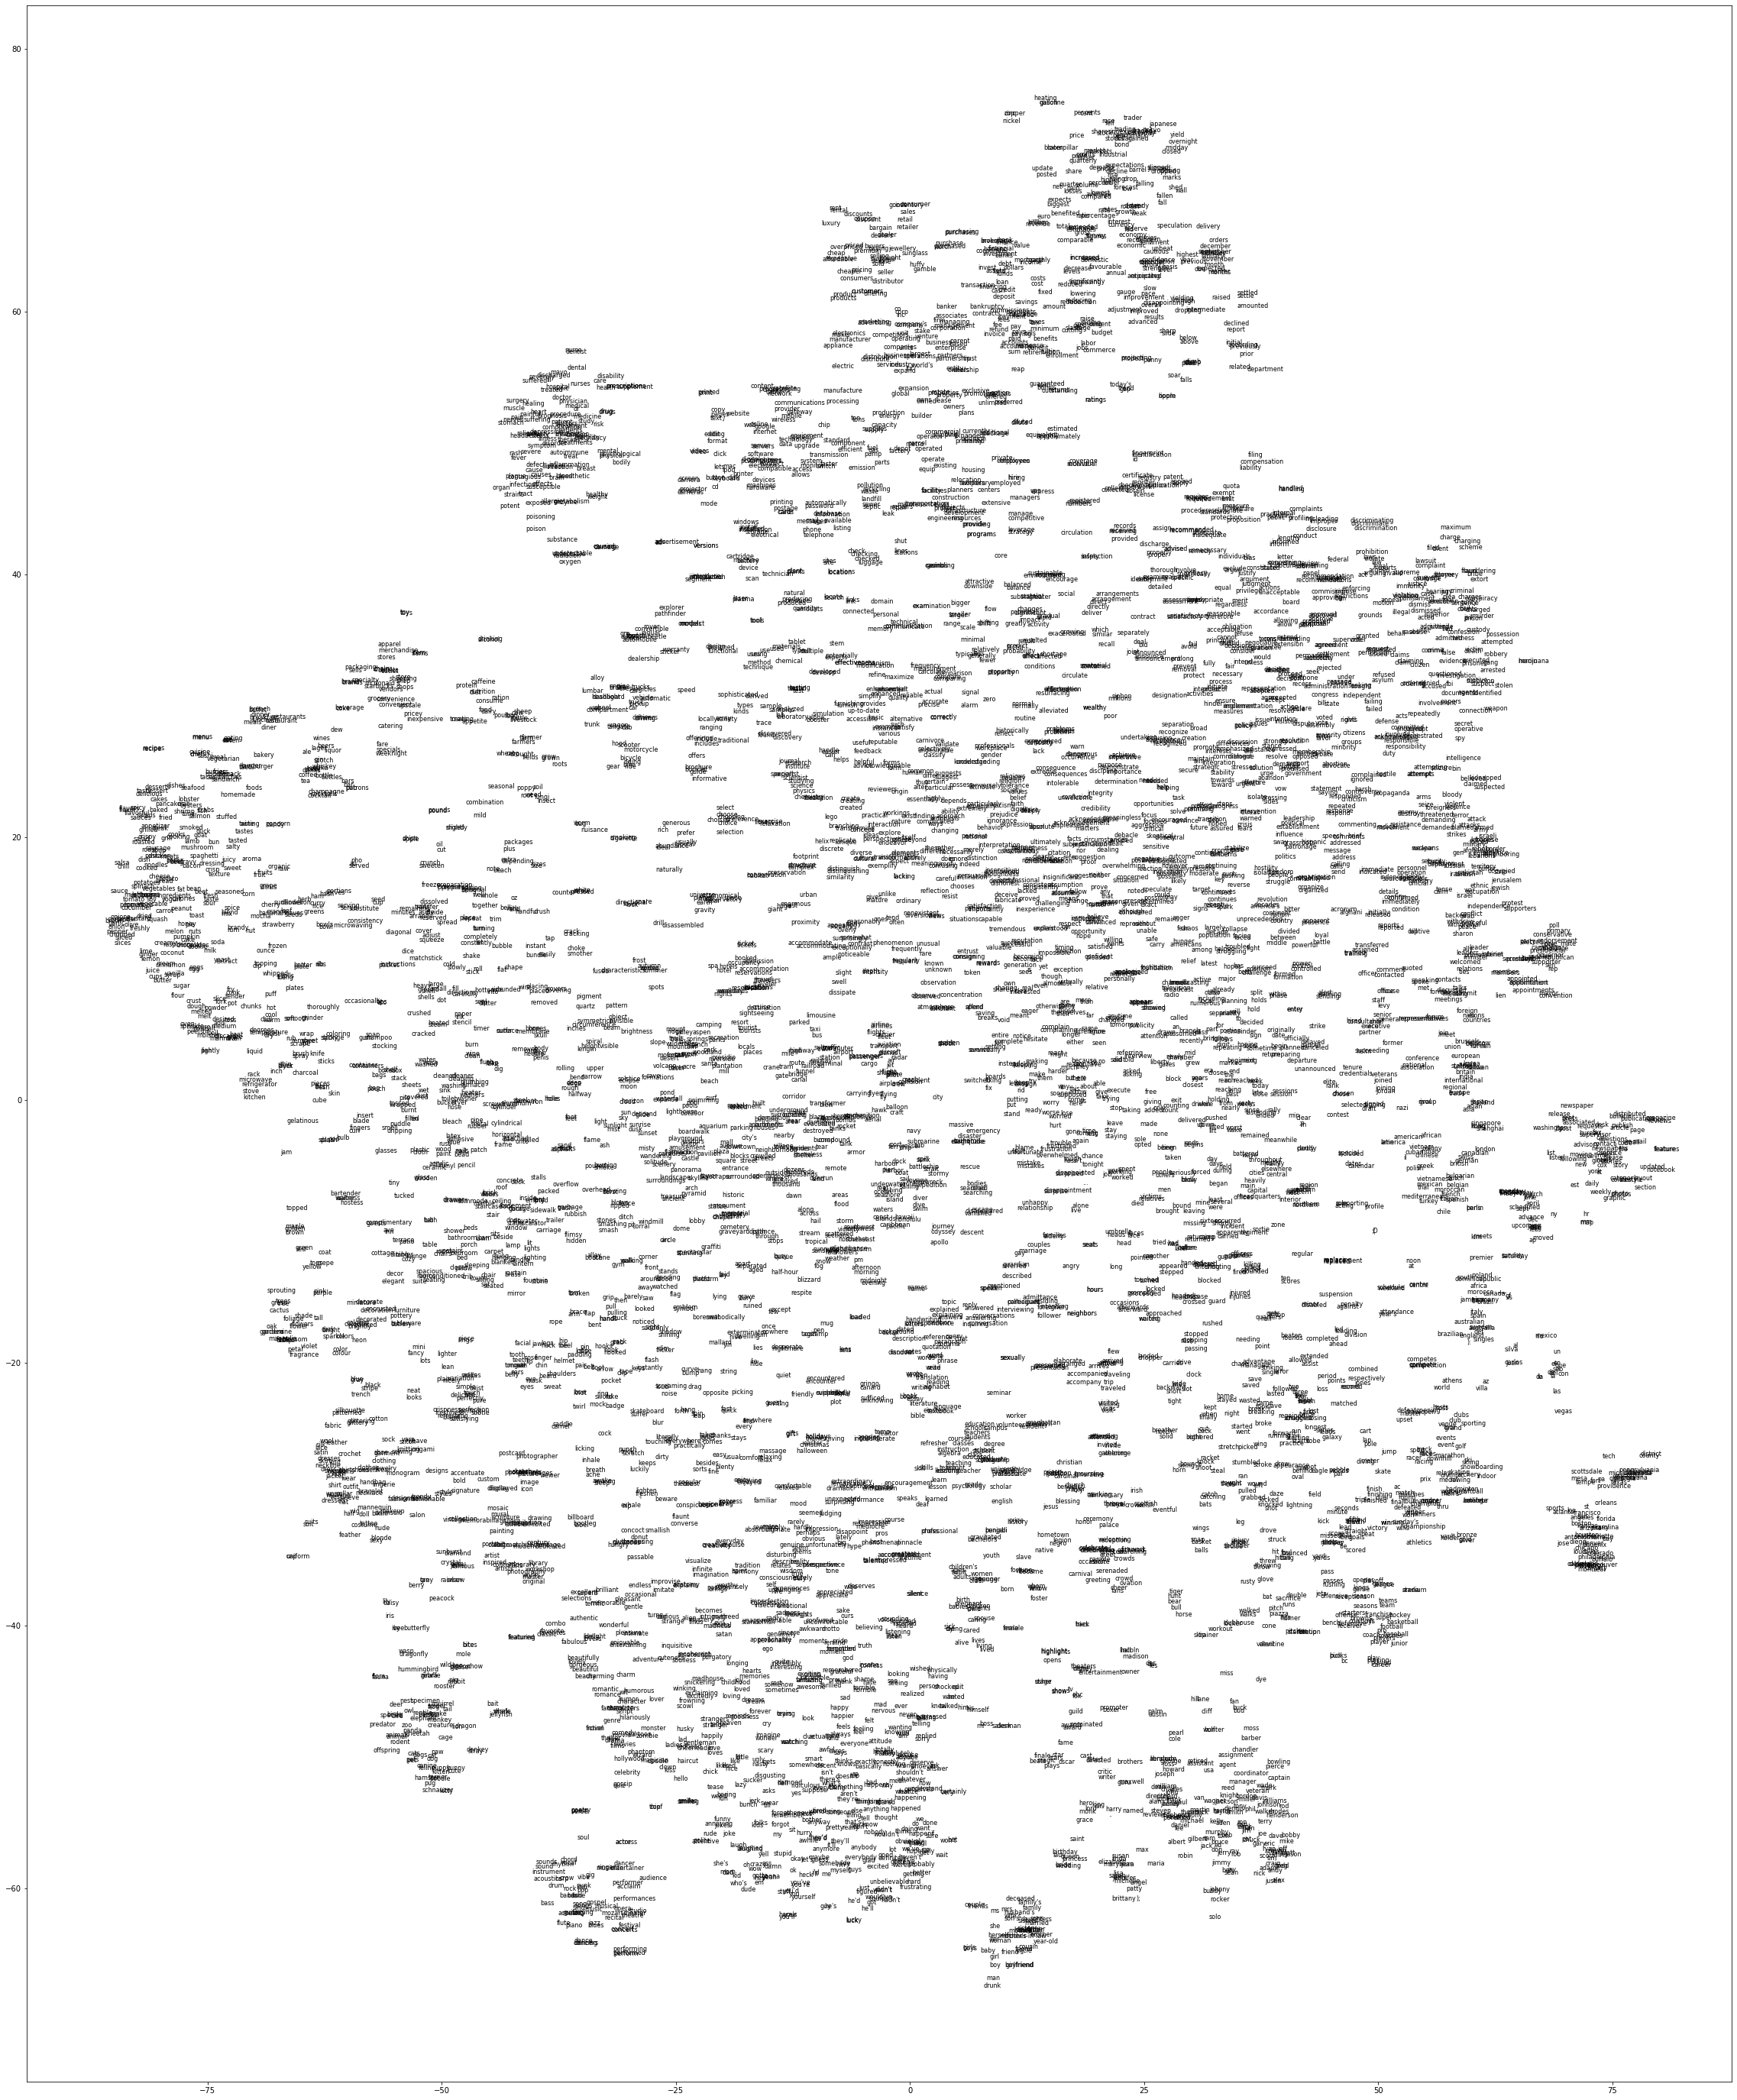

In [62]:
vsm.tsne_viz(ppmi, output_filename=None, figsize=(40, 50), random_state=42)

<h1>Baseline: PPMI</h1>

In [52]:
def apply_ppmi(df):
    return vsm.pmi(df)

def evaluate(df):
    pred_df, rho = vsm.word_relatedness_evaluation(dev_df, df)
    print(rho)
    return rho

def ppmi_model():
    pipeline = apply_ppmi(count_df)
    return pipeline

# ppmi = ppmi_model()
# evaluate(ppmi) # 0.35078317826072747

In [58]:
# here we are going to try using the combined_df
# hypothesis: this essentially brings in more data, so maybe results will improve
# although, the data could be very different -> make results worse...
evaluate(apply_ppmi(combined_df)) # 0.34506314450395015

# Result: slightly worse than giga20 alone

0.34506314450395015


0.34506314450395015

In [59]:
# Try the yelp dataset alone
evaluate(apply_ppmi(yelp_df)) # 0.2681669369260301
# why is this so much worse than gigaword dataset?

0.2681669369260301


0.2681669369260301

<h1>PPMI - LSA</h1>
<h2> Iterate through a few values of k for LSA </h2>

In [42]:
def apply_lsa(df, k):
    return vsm.lsa(df, k=k)

def ppmi_lsa_model(k):
    print(k)
    #ppmi = ppmi_model
    ppmi = apply_ppmi(count_df)
    pipeline = apply_lsa(ppmi, k)
    return pipeline

k_values = [55, 75]
for k in k_values:
    evaluate(ppmi_lsa_model(k=k))

55
0.37361430680403135
75
0.3780506404505552


In [ ]:
# try for some combined dataset and yelp dataset
# for k in [25, 50, 100]:
#     evaluate(apply_lsa(apply_ppmi(combined_df), k))
#     evaluate(apply_lsa(apply_ppmi(yelp_df), k))

# results:
# 0.32397790824401773
# 0.273638229822923
# 0.3440280665365778
# 0.29190854734437527
# 0.3543426961440956
# (aborted yelp k=100)
# it looks like this consistently underperforms 
# compared to gigaword dataset alone

Record of values of k tried and resulting rho:

| k | rho | 
| --- | --- |
|5  | 0.2690793493940406 |
|10 | 0.3188110541644582 |
|15 | 0.33787063311107074 |
|20 | 0.3494470390248065 |
|23 | 0.35493003920064664 |
|25 | 0.35801029120400735 |
|27 | 0.3605741064664968 |
|29 | 0.3634646054248036 |
|30 | 0.3641395062507528 |
|35 | 0.36595271827140213 |
|55 | 0.37361430680403135 |
|75 | 0.3780506404505552 |
|100 | 0.3804359519023298 |
|200 | 0.37933931313996916 |
|300 | 0.3704844541599484 |

Need k>=23 in order to have an improvement over PPMI baseline.

Plotted in below cell.

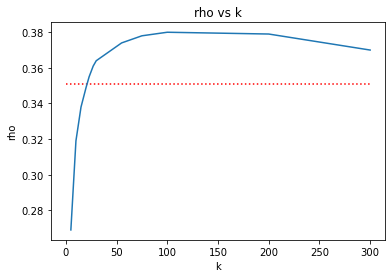

In [43]:
import matplotlib
import matplotlib.pyplot as plt

ks = [5, 10, 15, 20, 23, 25, 27, 29, 30, 35, 55, 75, 100, 200, 300]
rhos = [0.269, 0.319, 0.338, 0.349, 0.355, 0.358, 0.361, 0.363, 0.364, 0.366, 0.374, 0.378, 0.380, 0.379, 0.370]

fig, ax = plt.subplots()
ax.set(xlabel='k', ylabel='rho', title='rho vs k')
ax.plot(ks, rhos)
ax.hlines(0.351, 0, 300, colors='red', linestyles='dotted', label='ppmi')
plt.show()

Note: the above assumes we can optimize the k in LSA separately from the effects of the rest of the pipeline. Another option would be to tune the value of k using the entire pipeline.

Based on the above, choose k=100 for now.

<h1>PPMI - LSA - Retrofit</h1>

In [44]:
# initial attempt

# get ppmi - lsa model
ppmi_lsa = ppmi_lsa_model(k=100)
print(ppmi_lsa.shape)

100
(6000, 100)


In [65]:
vsm.neighbors('superb', ppmi_lsa).head()

# compared to vsm.neighbors('superb', ppmi).head() these distances
# are a lot shorter, meaning the words are more similar in this vsm

# Realization: we don't necessarily want our words to be similar by
# some absolute measure; we need it to "match" the scoring in the 
# relatedness dev_df since this is what we want the outputs to be like.
# How can we incorporate the dev_df into the processing we do on the
# vsm? Currently, only using it in the final evaluation!!

superb         0.000000
excellent      0.118194
terrific       0.138579
perfect        0.142211
beautifully    0.146424
dtype: float64

In [19]:
from nltk.corpus import wordnet as wn
import retrofitting
from retrofitting import Retrofitter

In [20]:
# retrofit helper functions copied from notebook
def get_wordnet_edges():
    edges = defaultdict(set)
    for ss in wn.all_synsets():
        lem_names = {lem.name() for lem in ss.lemmas()}
        for lem in lem_names:
            edges[lem] |= lem_names
    return edges

def convert_edges_to_indices(edges, Q):
    lookup = dict(zip(Q.index, range(Q.shape[0])))
    index_edges = defaultdict(set)
    for start, finish_nodes in edges.items():
        s = lookup.get(start)
        if s:
            f = {lookup[n] for n in finish_nodes if n in lookup}
            if f:
                index_edges[s] = f
    return index_edges

In [45]:
wn_edges = get_wordnet_edges()
wn_index_edges = convert_edges_to_indices(wn_edges, ppmi_lsa)
wn_retro = Retrofitter(verbose=True)
retro_df = wn_retro.fit(ppmi_lsa, wn_index_edges)
evaluate(retro_df) # k=29: 0.34290076857196167

Converged at iteration 10; change was 0.0063 

0.3526855467031869


In [53]:
# try other values of alpha
alphas = [5, 10, 15, 20]
results = []
for alpha in alphas:
    print(alpha)
    wn_retro = Retrofitter(alpha=lambda x: alpha, verbose=True)
    retro_df = wn_retro.fit(ppmi_lsa, wn_index_edges)
    results.append(evaluate(retro_df))

# very large alpha starts giving results better than baseline
# so we want vsm to dominate, but just incorporate a little of wordnet?
# as alpha increase, # of iterations until converge decreases

5


Converged at iteration 5; change was 0.0031 

0.38051751210397267
10


Converged at iteration 4; change was 0.0026 

0.3812425385752641
15


Converged at iteration 4; change was 0.0006 

0.3811872428068117
20


Converged at iteration 3; change was 0.0070 

0.38107864472426806


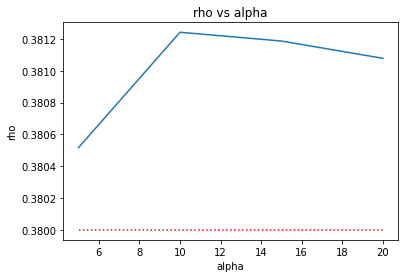

In [55]:
# currently, best value is alpha = 10.

fig, ax = plt.subplots()
ax.set(xlabel='alpha', ylabel='rho', title='rho vs alpha')
ax.plot(alphas, results)
ax.hlines(0.38, 5, 20, colors='red', linestyles='dotted', label='ppmi-lsa')
plt.show()

In [56]:
# FAILED ATTEMPT
# from paper: retrofit was better with longer vector length
# so maybe only do ppmi -> retrofit
# ppmi = ppmi_model()
# print(ppmi.shape)

# wn_edges = get_wordnet_edges()
# wn_index_edges = convert_edges_to_indices(wn_edges, ppmi)
# wn_retro = Retrofitter(verbose=True)
# retro_df = wn_retro.fit(ppmi, wn_index_edges)
# evaluate(retro_df) # 0.2908358495266217

# Result: it was much worse than a smaller value of k.

<h1>GloVe</h1>

Go back to using only gigaword vsm.

In [66]:
from torch_glove import TorchGloVe

In [73]:
# after 100 iters: error = 5345803.6875, score = -0.2ish?
# after 300 iters: error = 4853919.6255, score = -0.19
# these are with default embed_dim=100

# try increasing embed_dim to 1000 with iter=100
# after 100 iters: error = 4605204.625, score = -0.175

# try retaining full dim of 6000??
# after 100 iters: error = 2066223.5375, score = 0.020
# neighbors finally look reasonable although not exactly matching
glove_model = TorchGloVe(max_iter=100, embed_dim=6000)
glove_df = glove_model.fit(count_df)
evaluate(glove_df)

Finished epoch 100 of 100; error is 2066223.5375

0.020208282263670295


0.020208282263670295

In [74]:
vsm.neighbors('superb', glove_df).head()

superb        0.000000
brilliant     0.157920
impressive    0.166645
classic       0.181595
memorable     0.183558
dtype: float64

In [76]:
# sanity check if I can reproduce ref notebook results with yelp5
# resulting error = 1634338.84375; similar to ref notebook
# score is still pretty bad: -0.044
# however, better score than giga20
yelp5_df = pd.read_csv(os.path.join(VSM_HOME, 'yelp_window5-scaled.csv.gz'), index_col=0)
gloveyelp5_model = TorchGloVe(max_iter=100)
gloveyelp5_df = gloveyelp5_model.fit(yelp5_df)
evaluate(gloveyelp5_df)

Finished epoch 100 of 100; error is 1634338.84375

-0.04385115275952578


-0.04385115275952578

Summary of runs tried so far

| vsm | dim | iters | error (rounded) | score (rounded) |
| --- | --- | --- | --- | --- |
| giga20 | 100 | 100 | 5350000 | -0.2 |
| giga20 | 100 | 300 | 4850000 | -0.19 |
| giga20 | 1000 | 100 | 4610000 | -0.175 | 
| giga20 | 6000 | 100 | 2070000 | 0.020 |
| yelp5 | 100 | 100 | 1630000 | -0.044 |